# 1.Librerias


Importar algunas librerías y el Corpus almacenado en el drive

In [ ]:
#Importar ciertas librerias y montar el drive donde se guarda el corpus
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style(style = 'whitegrid')
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2.Análisis del Dataset

Se lee el csv y se eliminan los últimos 12000 tweets

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/TFG/corpusFinalTFGDEF.csv", sep = ";", header = None)

dataset.head(6)
dataset.drop(dataset.tail(12000).index, 
      inplace = True)

,0,1
0,"Portada 'Público', viernes. Fabra al banquillo...",N
1,"Grande! RT @veronicacalderon ""El periodista es...",NONE
2,Gonzalo Altozano tras la presentación de su li...,P
3,"Mañana en Gaceta: TVE, la que pagamos tú y yo,...",N
4,Qué envidia “@mfcastineiras: Pedro mañana x la...,NONE
5,Más mañana en Gaceta. Amaiur depende de Uxue B...,N


Se nombran a las columnas para organizar los tweets y la polaridad

In [ ]:
dataset.columns = ["Tweet", "Rating_Polarity"]

Gráfico que muestra la distribución de los tweets del dataset en función de la polaridad

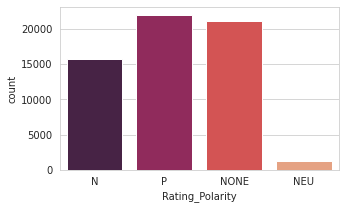

In [ ]:
plt.figure(figsize=(5, 3))
sns.countplot(x = 'Rating_Polarity', data = dataset, palette = 'rocket',
              # order=['Negative', 'Positive', 'None', 'Neutral']);
              order=['N', 'P', 'NONE', 'NEU']);

Se crean 3 datasets uno por cada clase para imprimir el número de tweets de cada clase

In [ ]:
dataset_Positive = dataset[dataset['Rating_Polarity'] == 'P']
#dataset_Positive= dataset_Positive[:15000]
#Si queremos eliminar NEU al ser el menor dataset
#dataset_Neutral = dataset[dataset['Rating_Polarity'] == 'NEU']
dataset_Negative = dataset[dataset['Rating_Polarity'] == 'N']
#dataset_Negative= dataset_Negative[:15000]
dataset_None = dataset[dataset['Rating_Polarity'] == 'NONE']
#dataset_None= dataset_None[:15000]
#Si queremos concatenar NEU y NONE
#dataset_None = pd.concat([dataset_None, dataset_Neutral], axis = 0)



# Hemos sumado las NEU a las NONE
print("NÚMERO DE TWEETS:\n",
      "\nPositive   ", len(dataset_Positive),
      "\nNegative   ", len(dataset_Negative),
    #  "\nNeutral    ", len(dataset_Neutral),
      "\nNone       ", len(dataset_None))

NÚMERO DE TWEETS:
 
Positive    25836 
Negative    20007 
None        23046


Dataset

In [ ]:
#dataset = pd.concat([dataset_Positive, dataset_Neutral, dataset_Negative, dataset_None], axis = 0)
dataset = pd.concat([dataset_Positive, dataset_Negative, dataset_None], axis = 0)
#dataset = pd.concat([dataset_Positive, dataset_Negative], axis = 0)
dataset

,Tweet,Rating_Polarity
2,Gonzalo Altozano tras la presentación de su li...,P
6,"Muy buenas noches followercetes, mañana va a s...",P
7,Más de mañana en Gaceta. UPyD contará casi seg...,P
8,"La felicidad no esta en los grandes anhelos , ...",P
11,"Habia prometido responder a todos, pero me ha ...",P
...,...,...
72123,Las 7 y cuarto y yo aquí,NONE
72124,"@WaterLiliesMon_ no las des, en serio.",NONE
72133,Tengo los md abiertos Crushes,NONE
72137,@ibk_lx7 Ps porque tú lo eres conmigo,NONE


Importar bibliotecas

In [ ]:
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Descargar e importar lematizador de spacy

In [ ]:
!python -m spacy download es_core_news_sm
import es_core_news_sm
nlp = es_core_news_sm.load()

Descargar e importar lematizador stanza

In [ ]:
!pip install stanza -U

In [ ]:
import stanza

stanza.download('es')
nlp = stanza.Pipeline('es')

2022-05-06 08:45:48 INFO: Downloading default packages for language: es (Spanish)...


2022-05-06 08:46:15 INFO: Finished downloading models and saved to /root/stanza_resources.


2022-05-06 08:46:19 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2022-05-06 08:46:19 INFO: Use device: cpu
2022-05-06 08:46:19 INFO: Loading: tokenize
2022-05-06 08:46:19 INFO: Loading: mwt
2022-05-06 08:46:19 INFO: Loading: pos
2022-05-06 08:46:20 INFO: Loading: lemma
2022-05-06 08:46:20 INFO: Loading: depparse
2022-05-06 08:46:21 INFO: Loading: ner
2022-05-06 08:46:24 INFO: Done loading processors!


# 3.Procesado de Tweets

Función de preprocesado y tokenización de tweets

In [ ]:
import re

from nltk import TweetTokenizer
import spacy
from nltk.stem import SnowballStemmer
#import es_core_news_sm
#nlp = es_core_news_sm.load()
# Creamos la funcion 'procesado' que va a borrar stopwords y algunos caracteres peculiares de twitter:

def procesado(text):
    
  # stopWords = set(stopwords.words('spanish'))
  # stopWords = {'a', 'al', 'algo', 'algunas', 'algunos', 'ante', 'antes', 'como', 'con', 'contra', 'cual', 'cuando', 'de', 'del', 'desde', 'donde', 'durante', 'e', 'el', 'ella', 'ellas', 'ellos', 'en', 'entre', 'era', 'erais', 'eran', 'eras', 'eres', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'estaba', 'estabais', 'estaban', 'estabas', 'estad', 'estada', 'estadas', 'estado', 'estados', 'estamos', 'estando', 'estar', 'estaremos', 'estará', 'estarán', 'estarás', 'estaré', 'estaréis', 'estaría', 'estaríais', 'estaríamos', 'estarían', 'estarías', 'estas', 'este', 'estemos', 'esto', 'estos', 'estoy', 'estuve', 'estuviera', 'estuvierais', 'estuvieran', 'estuvieras', 'estuvieron', 'estuviese', 'estuvieseis', 'estuviesen', 'estuvieses', 'estuvimos', 'estuviste', 'estuvisteis', 'estuviéramos', 'estuviésemos', 'estuvo', 'está', 'estábamos', 'estáis', 'están', 'estás', 'esté', 'estéis', 'estén', 'estés', 'fue', 'fuera', 'fuerais', 'fueran', 'fueras', 'fueron', 'fuese', 'fueseis', 'fuesen', 'fueses', 'fui', 'fuimos', 'fuiste', 'fuisteis', 'fuéramos', 'fuésemos', 'ha', 'habida', 'habidas', 'habido', 'habidos', 'habiendo', 'habremos', 'habrá', 'habrán', 'habrás', 'habré', 'habréis', 'habría', 'habríais', 'habríamos', 'habrían', 'habrías', 'habéis', 'había', 'habíais', 'habíamos', 'habían', 'habías', 'han', 'has', 'hasta', 'hay', 'haya', 'hayamos', 'hayan', 'hayas', 'hayáis', 'he', 'hemos', 'hube', 'hubiera', 'hubierais', 'hubieran', 'hubieras', 'hubieron', 'hubiese', 'hubieseis', 'hubiesen', 'hubieses', 'hubimos', 'hubiste', 'hubisteis', 'hubiéramos', 'hubiésemos', 'hubo', 'la', 'las', 'le', 'les', 'lo', 'los', 'me', 'mi', 'mis', 'mucho', 'muchos', 'muy', 'más', 'mí', 'mía', 'mías', 'mío', 'míos', 'nada', 'ni', 'no', 'nos', 'nosotras', 'nosotros', 'nuestra', 'nuestras', 'nuestro', 'nuestros', 'o', 'os', 'otra', 'otras', 'otro', 'otros', 'para', 'pero', 'poco', 'por', 'porque', 'que', 'quien', 'quienes', 'qué', 'se', 'sea', 'seamos', 'sean', 'seas', 'sentid', 'sentida', 'sentidas', 'sentido', 'sentidos', 'seremos', 'será', 'serán', 'serás', 'seré', 'seréis', 'sería', 'seríais', 'seríamos', 'serían', 'serías', 'seáis', 'siente', 'sin', 'sintiendo', 'sobre', 'sois', 'somos', 'son', 'soy', 'su', 'sus', 'suya', 'suyas', 'suyo', 'suyos', 'sí', 'también', 'tanto', 'te', 'tendremos', 'tendrá', 'tendrán', 'tendrás', 'tendré', 'tendréis', 'tendría', 'tendríais', 'tendríamos', 'tendrían', 'tendrías', 'tened', 'tenemos', 'tenga', 'tengamos', 'tengan', 'tengas', 'tengo', 'tengáis', 'tenida', 'tenidas', 'tenido', 'tenidos', 'teniendo', 'tenéis', 'tenía', 'teníais', 'teníamos', 'tenían', 'tenías', 'ti', 'tiene', 'tienen', 'tienes', 'todo', 'todos', 'tu', 'tus', 'tuve', 'tuviera', 'tuvierais', 'tuvieran', 'tuvieras', 'tuvieron', 'tuviese', 'tuvieseis', 'tuviesen', 'tuvieses', 'tuvimos', 'tuviste', 'tuvisteis', 'tuviéramos', 'tuviésemos', 'tuvo', 'tuya', 'tuyas', 'tuyo', 'tuyos', 'tú', 'un', 'una', 'uno', 'unos', 'vosotras', 'vosotros', 'vuestra', 'vuestras', 'vuestro', 'vuestros', 'y', 'ya', 'yo', 'él', 'éramos'}
    
  # stopWords_sin_no_ni = {'a', 'al', 'algo', 'algunas', 'algunos', 'ante', 'antes', 'como', 'con', 'contra', 'cual', 'cuando', 'de', 'del', 'desde', 'donde', 'durante', 'e', 'el', 'ella', 'ellas', 'ellos', 'en', 'entre', 'era', 'erais', 'eran', 'eras', 'eres', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'estaba', 'estabais', 'estaban', 'estabas', 'estad', 'estada', 'estadas', 'estado', 'estados', 'estamos', 'estando', 'estar', 'estaremos', 'estará', 'estarán', 'estarás', 'estaré', 'estaréis', 'estaría', 'estaríais', 'estaríamos', 'estarían', 'estarías', 'estas', 'este', 'estemos', 'esto', 'estos', 'estoy', 'estuve', 'estuviera', 'estuvierais', 'estuvieran', 'estuvieras', 'estuvieron', 'estuviese', 'estuvieseis', 'estuviesen', 'estuvieses', 'estuvimos', 'estuviste', 'estuvisteis', 'estuviéramos', 'estuviésemos', 'estuvo', 'está', 'estábamos', 'estáis', 'están', 'estás', 'esté', 'estéis', 'estén', 'estés', 'fue', 'fuera', 'fuerais', 'fueran', 'fueras', 'fueron', 'fuese', 'fueseis', 'fuesen', 'fueses', 'fui', 'fuimos', 'fuiste', 'fuisteis', 'fuéramos', 'fuésemos', 'ha', 'habida', 'habidas', 'habido', 'habidos', 'habiendo', 'habremos', 'habrá', 'habrán', 'habrás', 'habré', 'habréis', 'habría', 'habríais', 'habríamos', 'habrían', 'habrías', 'habéis', 'había', 'habíais', 'habíamos', 'habían', 'habías', 'han', 'has', 'hasta', 'hay', 'haya', 'hayamos', 'hayan', 'hayas', 'hayáis', 'he', 'hemos', 'hube', 'hubiera', 'hubierais', 'hubieran', 'hubieras', 'hubieron', 'hubiese', 'hubieseis', 'hubiesen', 'hubieses', 'hubimos', 'hubiste', 'hubisteis', 'hubiéramos', 'hubiésemos', 'hubo', 'la', 'las', 'le', 'les', 'lo', 'los', 'me', 'mi', 'mis', 'mucho', 'muchos', 'muy', 'más', 'mí', 'mía', 'mías', 'mío', 'míos', 'nada', 'nos', 'nosotras', 'nosotros', 'nuestra', 'nuestras', 'nuestro', 'nuestros', 'o', 'os', 'otra', 'otras', 'otro', 'otros', 'para', 'pero', 'poco', 'por', 'porque', 'que', 'quien', 'quienes', 'qué', 'se', 'sea', 'seamos', 'sean', 'seas', 'sentid', 'sentida', 'sentidas', 'sentido', 'sentidos', 'seremos', 'será', 'serán', 'serás', 'seré', 'seréis', 'sería', 'seríais', 'seríamos', 'serían', 'serías', 'seáis', 'siente', 'sin', 'sintiendo', 'sobre', 'sois', 'somos', 'son', 'soy', 'su', 'sus', 'suya', 'suyas', 'suyo', 'suyos', 'sí', 'también', 'tanto', 'te', 'tendremos', 'tendrá', 'tendrán', 'tendrás', 'tendré', 'tendréis', 'tendría', 'tendríais', 'tendríamos', 'tendrían', 'tendrías', 'tened', 'tenemos', 'tenga', 'tengamos', 'tengan', 'tengas', 'tengo', 'tengáis', 'tenida', 'tenidas', 'tenido', 'tenidos', 'teniendo', 'tenéis', 'tenía', 'teníais', 'teníamos', 'tenían', 'tenías', 'ti', 'tiene', 'tienen', 'tienes', 'todo', 'todos', 'tu', 'tus', 'tuve', 'tuviera', 'tuvierais', 'tuvieran', 'tuvieras', 'tuvieron', 'tuviese', 'tuvieseis', 'tuviesen', 'tuvieses', 'tuvimos', 'tuviste', 'tuvisteis', 'tuviéramos', 'tuviésemos', 'tuvo', 'tuya', 'tuyas', 'tuyo', 'tuyos', 'tú', 'un', 'una', 'uno', 'unos', 'vosotras', 'vosotros', 'vuestra', 'vuestras', 'vuestro', 'vuestros', 'y', 'ya', 'yo', 'él', 'éramos'}
  # stopWords_sin_no = {'a', 'al', 'algo', 'algunas', 'algunos', 'ante', 'antes', 'como', 'con', 'contra', 'cual', 'cuando', 'de', 'del', 'desde', 'donde', 'durante', 'e', 'el', 'ella', 'ellas', 'ellos', 'en', 'entre', 'era', 'erais', 'eran', 'eras', 'eres', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'estaba', 'estabais', 'estaban', 'estabas', 'estad', 'estada', 'estadas', 'estado', 'estados', 'estamos', 'estando', 'estar', 'estaremos', 'estará', 'estarán', 'estarás', 'estaré', 'estaréis', 'estaría', 'estaríais', 'estaríamos', 'estarían', 'estarías', 'estas', 'este', 'estemos', 'esto', 'estos', 'estoy', 'estuve', 'estuviera', 'estuvierais', 'estuvieran', 'estuvieras', 'estuvieron', 'estuviese', 'estuvieseis', 'estuviesen', 'estuvieses', 'estuvimos', 'estuviste', 'estuvisteis', 'estuviéramos', 'estuviésemos', 'estuvo', 'está', 'estábamos', 'estáis', 'están', 'estás', 'esté', 'estéis', 'estén', 'estés', 'fue', 'fuera', 'fuerais', 'fueran', 'fueras', 'fueron', 'fuese', 'fueseis', 'fuesen', 'fueses', 'fui', 'fuimos', 'fuiste', 'fuisteis', 'fuéramos', 'fuésemos', 'ha', 'habida', 'habidas', 'habido', 'habidos', 'habiendo', 'habremos', 'habrá', 'habrán', 'habrás', 'habré', 'habréis', 'habría', 'habríais', 'habríamos', 'habrían', 'habrías', 'habéis', 'había', 'habíais', 'habíamos', 'habían', 'habías', 'han', 'has', 'hasta', 'hay', 'haya', 'hayamos', 'hayan', 'hayas', 'hayáis', 'he', 'hemos', 'hube', 'hubiera', 'hubierais', 'hubieran', 'hubieras', 'hubieron', 'hubiese', 'hubieseis', 'hubiesen', 'hubieses', 'hubimos', 'hubiste', 'hubisteis', 'hubiéramos', 'hubiésemos', 'hubo', 'la', 'las', 'le', 'les', 'lo', 'los', 'me', 'mi', 'mis', 'mucho', 'muchos', 'muy', 'más', 'mí', 'mía', 'mías', 'mío', 'míos', 'nada', 'ni', 'nos', 'nosotras', 'nosotros', 'nuestra', 'nuestras', 'nuestro', 'nuestros', 'o', 'os', 'otra', 'otras', 'otro', 'otros', 'para', 'pero', 'poco', 'por', 'porque', 'que', 'quien', 'quienes', 'qué', 'se', 'sea', 'seamos', 'sean', 'seas', 'sentid', 'sentida', 'sentidas', 'sentido', 'sentidos', 'seremos', 'será', 'serán', 'serás', 'seré', 'seréis', 'sería', 'seríais', 'seríamos', 'serían', 'serías', 'seáis', 'siente', 'sin', 'sintiendo', 'sobre', 'sois', 'somos', 'son', 'soy', 'su', 'sus', 'suya', 'suyas', 'suyo', 'suyos', 'sí', 'también', 'tanto', 'te', 'tendremos', 'tendrá', 'tendrán', 'tendrás', 'tendré', 'tendréis', 'tendría', 'tendríais', 'tendríamos', 'tendrían', 'tendrías', 'tened', 'tenemos', 'tenga', 'tengamos', 'tengan', 'tengas', 'tengo', 'tengáis', 'tenida', 'tenidas', 'tenido', 'tenidos', 'teniendo', 'tenéis', 'tenía', 'teníais', 'teníamos', 'tenían', 'tenías', 'ti', 'tiene', 'tienen', 'tienes', 'todo', 'todos', 'tu', 'tus', 'tuve', 'tuviera', 'tuvierais', 'tuvieran', 'tuvieras', 'tuvieron', 'tuviese', 'tuvieseis', 'tuviesen', 'tuvieses', 'tuvimos', 'tuviste', 'tuvisteis', 'tuviéramos', 'tuviésemos', 'tuvo', 'tuya', 'tuyas', 'tuyo', 'tuyos', 'tú', 'un', 'una', 'uno', 'unos', 'vosotras', 'vosotros', 'vuestra', 'vuestras', 'vuestro', 'vuestros', 'y', 'ya', 'yo', 'él', 'éramos'}
  stopWords_sin__no_ni_prep = {'al', 'algo', 'algunas', 'algunos', 'antes', 'como', 'cual', 'cuando', 'del', 'donde', 'durante', 'e', 'el', 'ella', 'ellas', 'ellos', 'era', 'erais', 'eran', 'eras', 'eres', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'estaba', 'estabais', 'estaban', 'estabas', 'estad', 'estada', 'estadas', 'estado', 'estados', 'estamos', 'estando', 'estar', 'estaremos', 'estará', 'estarán', 'estarás', 'estaré', 'estaréis', 'estaría', 'estaríais', 'estaríamos', 'estarían', 'estarías', 'estas', 'este', 'estemos', 'esto', 'estos', 'estoy', 'estuve', 'estuviera', 'estuvierais', 'estuvieran', 'estuvieras', 'estuvieron', 'estuviese', 'estuvieseis', 'estuviesen', 'estuvieses', 'estuvimos', 'estuviste', 'estuvisteis', 'estuviéramos', 'estuviésemos', 'estuvo', 'está', 'estábamos', 'estáis', 'están', 'estás', 'esté', 'estéis', 'estén', 'estés', 'fue', 'fuera', 'fuerais', 'fueran', 'fueras', 'fueron', 'fuese', 'fueseis', 'fuesen', 'fueses', 'fui', 'fuimos', 'fuiste', 'fuisteis', 'fuéramos', 'fuésemos', 'ha', 'habida', 'habidas', 'habido', 'habidos', 'habiendo', 'habremos', 'habrá', 'habrán', 'habrás', 'habré', 'habréis', 'habría', 'habríais', 'habríamos', 'habrían', 'habrías', 'habéis', 'había', 'habíais', 'habíamos', 'habían', 'habías', 'han', 'has', 'hay', 'haya', 'hayamos', 'hayan', 'hayas', 'hayáis', 'he', 'hemos', 'hube', 'hubiera', 'hubierais', 'hubieran', 'hubieras', 'hubieron', 'hubiese', 'hubieseis', 'hubiesen', 'hubieses', 'hubimos', 'hubiste', 'hubisteis', 'hubiéramos', 'hubiésemos', 'hubo', 'la', 'las', 'le', 'les', 'lo', 'los', 'me', 'mi', 'mis', 'mucho', 'muchos', 'muy', 'más', 'mí', 'mía', 'mías', 'mío', 'míos', 'nada', 'nos', 'nosotras', 'nosotros', 'nuestra', 'nuestras', 'nuestro', 'nuestros', 'o', 'os', 'otra', 'otras', 'otro', 'otros', 'pero', 'poco', 'porque', 'que', 'quien', 'quienes', 'qué', 'se', 'sea', 'seamos', 'sean', 'seas', 'sentid', 'sentida', 'sentidas', 'sentido', 'sentidos', 'seremos', 'será', 'serán', 'serás', 'seré', 'seréis', 'sería', 'seríais', 'seríamos', 'serían', 'serías', 'seáis', 'siente', 'sintiendo', 'sois', 'somos', 'son', 'soy', 'su', 'sus', 'suya', 'suyas', 'suyo', 'suyos', 'sí', 'también', 'tanto', 'te', 'tendremos', 'tendrá', 'tendrán', 'tendrás', 'tendré', 'tendréis', 'tendría', 'tendríais', 'tendríamos', 'tendrían', 'tendrías', 'tened', 'tenemos', 'tenga', 'tengamos', 'tengan', 'tengas', 'tengo', 'tengáis', 'tenida', 'tenidas', 'tenido', 'tenidos', 'teniendo', 'tenéis', 'tenía', 'teníais', 'teníamos', 'tenían', 'tenías', 'ti', 'tiene', 'tienen', 'tienes', 'todo', 'todos', 'tu', 'tus', 'tuve', 'tuviera', 'tuvierais', 'tuvieran', 'tuvieras', 'tuvieron', 'tuviese', 'tuvieseis', 'tuviesen', 'tuvieses', 'tuvimos', 'tuviste', 'tuvisteis', 'tuviéramos', 'tuviésemos', 'tuvo', 'tuya', 'tuyas', 'tuyo', 'tuyos', 'tú', 'un', 'una', 'uno', 'unos', 'vosotras', 'vosotros', 'vuestra', 'vuestras', 'vuestro', 'vuestros', 'y', 'ya', 'yo', 'él', 'éramos'}
  # stopWords_sin_no_prep = {'al', 'algo', 'algunas', 'algunos', 'antes', 'como', 'cual', 'cuando', 'del', 'donde', 'durante', 'e', 'el', 'ella', 'ellas', 'ellos', 'era', 'erais', 'eran', 'eras', 'eres', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'estaba', 'estabais', 'estaban', 'estabas', 'estad', 'estada', 'estadas', 'estado', 'estados', 'estamos', 'estando', 'estar', 'estaremos', 'estará', 'estarán', 'estarás', 'estaré', 'estaréis', 'estaría', 'estaríais', 'estaríamos', 'estarían', 'estarías', 'estas', 'este', 'estemos', 'esto', 'estos', 'estoy', 'estuve', 'estuviera', 'estuvierais', 'estuvieran', 'estuvieras', 'estuvieron', 'estuviese', 'estuvieseis', 'estuviesen', 'estuvieses', 'estuvimos', 'estuviste', 'estuvisteis', 'estuviéramos', 'estuviésemos', 'estuvo', 'está', 'estábamos', 'estáis', 'están', 'estás', 'esté', 'estéis', 'estén', 'estés', 'fue', 'fuera', 'fuerais', 'fueran', 'fueras', 'fueron', 'fuese', 'fueseis', 'fuesen', 'fueses', 'fui', 'fuimos', 'fuiste', 'fuisteis', 'fuéramos', 'fuésemos', 'ha', 'habida', 'habidas', 'habido', 'habidos', 'habiendo', 'habremos', 'habrá', 'habrán', 'habrás', 'habré', 'habréis', 'habría', 'habríais', 'habríamos', 'habrían', 'habrías', 'habéis', 'había', 'habíais', 'habíamos', 'habían', 'habías', 'han', 'has', 'hay', 'haya', 'hayamos', 'hayan', 'hayas', 'hayáis', 'he', 'hemos', 'hube', 'hubiera', 'hubierais', 'hubieran', 'hubieras', 'hubieron', 'hubiese', 'hubieseis', 'hubiesen', 'hubieses', 'hubimos', 'hubiste', 'hubisteis', 'hubiéramos', 'hubiésemos', 'hubo', 'la', 'las', 'le', 'les', 'lo', 'los', 'me', 'mi', 'mis', 'mucho', 'muchos', 'muy', 'más', 'mí', 'mía', 'mías', 'mío', 'míos', 'nada', 'ni','nos', 'nosotras', 'nosotros', 'nuestra', 'nuestras', 'nuestro', 'nuestros', 'o', 'os', 'otra', 'otras', 'otro', 'otros', 'pero', 'poco', 'porque', 'que', 'quien', 'quienes', 'qué', 'se', 'sea', 'seamos', 'sean', 'seas', 'sentid', 'sentida', 'sentidas', 'sentido', 'sentidos', 'seremos', 'será', 'serán', 'serás', 'seré', 'seréis', 'sería', 'seríais', 'seríamos', 'serían', 'serías', 'seáis', 'siente', 'sintiendo', 'sois', 'somos', 'son', 'soy', 'su', 'sus', 'suya', 'suyas', 'suyo', 'suyos', 'sí', 'también', 'tanto', 'te', 'tendremos', 'tendrá', 'tendrán', 'tendrás', 'tendré', 'tendréis', 'tendría', 'tendríais', 'tendríamos', 'tendrían', 'tendrías', 'tened', 'tenemos', 'tenga', 'tengamos', 'tengan', 'tengas', 'tengo', 'tengáis', 'tenida', 'tenidas', 'tenido', 'tenidos', 'teniendo', 'tenéis', 'tenía', 'teníais', 'teníamos', 'tenían', 'tenías', 'ti', 'tiene', 'tienen', 'tienes', 'todo', 'todos', 'tu', 'tus', 'tuve', 'tuviera', 'tuvierais', 'tuvieran', 'tuvieras', 'tuvieron', 'tuviese', 'tuvieseis', 'tuviesen', 'tuvieses', 'tuvimos', 'tuviste', 'tuvisteis', 'tuviéramos', 'tuviésemos', 'tuvo', 'tuya', 'tuyas', 'tuyo', 'tuyos', 'tú', 'un', 'una', 'uno', 'unos', 'vosotras', 'vosotros', 'vuestra', 'vuestras', 'vuestro', 'vuestros', 'y', 'ya', 'yo', 'él', 'éramos'}
  # stopWords_sin_prep = {'al', 'algo', 'algunas', 'algunos', 'antes', 'como', 'cual', 'cuando', 'del', 'donde', 'durante', 'e', 'el', 'ella', 'ellas', 'ellos', 'era', 'erais', 'eran', 'eras', 'eres', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'estaba', 'estabais', 'estaban', 'estabas', 'estad', 'estada', 'estadas', 'estado', 'estados', 'estamos', 'estando', 'estar', 'estaremos', 'estará', 'estarán', 'estarás', 'estaré', 'estaréis', 'estaría', 'estaríais', 'estaríamos', 'estarían', 'estarías', 'estas', 'este', 'estemos', 'esto', 'estos', 'estoy', 'estuve', 'estuviera', 'estuvierais', 'estuvieran', 'estuvieras', 'estuvieron', 'estuviese', 'estuvieseis', 'estuviesen', 'estuvieses', 'estuvimos', 'estuviste', 'estuvisteis', 'estuviéramos', 'estuviésemos', 'estuvo', 'está', 'estábamos', 'estáis', 'están', 'estás', 'esté', 'estéis', 'estén', 'estés', 'fue', 'fuera', 'fuerais', 'fueran', 'fueras', 'fueron', 'fuese', 'fueseis', 'fuesen', 'fueses', 'fui', 'fuimos', 'fuiste', 'fuisteis', 'fuéramos', 'fuésemos', 'ha', 'habida', 'habidas', 'habido', 'habidos', 'habiendo', 'habremos', 'habrá', 'habrán', 'habrás', 'habré', 'habréis', 'habría', 'habríais', 'habríamos', 'habrían', 'habrías', 'habéis', 'había', 'habíais', 'habíamos', 'habían', 'habías', 'han', 'has', 'hay', 'haya', 'hayamos', 'hayan', 'hayas', 'hayáis', 'he', 'hemos', 'hube', 'hubiera', 'hubierais', 'hubieran', 'hubieras', 'hubieron', 'hubiese', 'hubieseis', 'hubiesen', 'hubieses', 'hubimos', 'hubiste', 'hubisteis', 'hubiéramos', 'hubiésemos', 'hubo', 'la', 'las', 'le', 'les', 'lo', 'los', 'me', 'mi', 'mis', 'mucho', 'muchos', 'muy', 'más', 'mí', 'mía', 'mías', 'mío', 'míos', 'nada', 'ni', 'no', 'nos', 'nosotras', 'nosotros', 'nuestra', 'nuestras', 'nuestro', 'nuestros', 'o', 'os', 'otra', 'otras', 'otro', 'otros', 'pero', 'poco', 'porque', 'que', 'quien', 'quienes', 'qué', 'se', 'sea', 'seamos', 'sean', 'seas', 'sentid', 'sentida', 'sentidas', 'sentido', 'sentidos', 'seremos', 'será', 'serán', 'serás', 'seré', 'seréis', 'sería', 'seríais', 'seríamos', 'serían', 'serías', 'seáis', 'siente', 'sintiendo', 'sois', 'somos', 'son', 'soy', 'su', 'sus', 'suya', 'suyas', 'suyo', 'suyos', 'sí', 'también', 'tanto', 'te', 'tendremos', 'tendrá', 'tendrán', 'tendrás', 'tendré', 'tendréis', 'tendría', 'tendríais', 'tendríamos', 'tendrían', 'tendrías', 'tened', 'tenemos', 'tenga', 'tengamos', 'tengan', 'tengas', 'tengo', 'tengáis', 'tenida', 'tenidas', 'tenido', 'tenidos', 'teniendo', 'tenéis', 'tenía', 'teníais', 'teníamos', 'tenían', 'tenías', 'ti', 'tiene', 'tienen', 'tienes', 'todo', 'todos', 'tu', 'tus', 'tuve', 'tuviera', 'tuvierais', 'tuvieran', 'tuvieras', 'tuvieron', 'tuviese', 'tuvieseis', 'tuviesen', 'tuvieses', 'tuvimos', 'tuviste', 'tuvisteis', 'tuviéramos', 'tuviésemos', 'tuvo', 'tuya', 'tuyas', 'tuyo', 'tuyos', 'tú', 'un', 'una', 'uno', 'unos', 'vosotras', 'vosotros', 'vuestra', 'vuestras', 'vuestro', 'vuestros', 'y', 'ya', 'yo', 'él', 'éramos'}
  
  DIACRITICAL_VOWELS = [('á','a'), ('é','e'), ('í','i'), ('ó','o'), ('ú','u'), ('ü','u')]
  
  SLANG = [('d','de'), ('[qk]','que'), ('xo','pero'), ('xa', 'para'), ('[xp]q','porque'),('es[qk]', 'es que'),
           ('fvr','favor'),('(xfa|xf|pf|plis|pls|porfa)', 'por favor'), ('dnd','donde'), ('tb', 'también'),
           ('(tq|tk)', 'te quiero'), ('(tqm|tkm)', 'te quiero mucho'), ('x','por'), ('\+','mas')]
  
  #Sustituirlo por variables predefinidas y contarlo
  text = str(text)
  text = re.sub(r'@[A-Za-z0-9]+', ' ', text)  # Borrar menciones @
  text = re.sub(r'RT[|\s]', ' ', text)        # Borrar RTs (Retweets)
  text = re.sub(r'#', ' ', text)              # Borrar # en el tweet
  text = re.sub(r'https?:\/\/\S+', ' ', text) # Borrar links
  
  stemming = True

  lemmatization = False

  #Stemming en español
  _stemmer = SnowballStemmer('spanish')
  #Se carga el modelo de lematización en español
  #nlp = spacy.load('es_core_news_sm')
  #Tokenizador de tweets
  _tokenizer = TweetTokenizer().tokenize
    
  _stemming = stemming


  # Convertir a minúsculas
  text = text.lower()
    
  # Borrar números, retornos de carro y retweets
  # text = re.sub(r'(\d+|\n|\brt\b)', '', text)
    
  # Borrar números y retornos de carro
  text = re.sub(r'(\d+|\n)', '', text)
    
  # Borrar vocales con marca diacrítica
  for s,t in DIACRITICAL_VOWELS:
    text = re.sub(r'{0}'.format(s), t, text)
  
  # Borrar caracteres repetidos
  text = re.sub(r'(.)\1{2,}', r'\1\1', text)
  
  # Normalizar la risa:
  #Sustituirlo por variables predefinidas y contarlo
  text = re.sub(r'\b(?=\w*[j])[aeiouj]{4,}\b', ' ', text)
  text = re.sub(r'\b(juas+|lol)\b', ' ', text)
  
  # translate slang (jergas)
  for s,t in SLANG:    
    text = re.sub(r'\b{0}\b'.format(s), t, text)
  

  pattern = r'''(?x)                  # Set flag to allow verbose regexps (Establece la bandera para permitir expresiones regulares detalladas)
              (?:[A-Z]\.)+            # Abbreviations, e.g. U.S.A (Abreviaturas, p. Ej. EE.UU)
              | \w+(?:-\w+)*          # Words with optional internal hyphens (Palabras con guiones internos opcionales)
              | \$?\d+(?:\.\d+)?%?    # Currency and precentages, e.g. $12.40 82% (Moneda y porcentajes, p. Ej. $ 12,40 82%)
              | \.\.\.                # Ellipsis (Puntos suspensivos)
              | [][.,;"'?():-_`]      # These are separate tokens; includes ],[ (Estos son tokens separados; incluye ],[)
              | [😀\😁\😂\🤣\😃\😄\😅\😆\😉\😊\😋\😎\😍\😘\😗\😙\😚\☺\🙂\🤗\🤩\😌\😛\😜\😝\🤤\🤑\😇\🤭\😺\😸\😹\😻\😽\💪\✌\🖐\✋\👌\👍\👋\👏\🙌\🙏\💋\💘\❤\💓\💔\💕\💖\💗\💙\💚\💛\🧡\💜\🖤\💝\💞\💟\❣\💌\🍺\🍻\🎉\🎊\🙋\🕺\💃] # \:d\:)\:-)\:-d\;d\;-)\=d\;)\:]\:-]\=)\=]\(:\xd\:p\:-p\8)\xp\<3
              | [:d]
              | [:)]
              #| [:-)]
              | [:-d]
              | [;d]
              #| [;-)]
              | [=d]
              | [;)]
              | [:]]
              | [:-]]
              | [=)]
              | [=]]
              | [(:]
              | [xd]
              | [:p]
              | [:-p]
              | [8)]
              | [xp]
              | [<3]
              | [🤔\🤨\😐\😑\😶\🙄\😏\😮\🤐\😯\😒\😕\🙃\😲\😼\🤷] # \:-|\:|]
              | [:-|]
              | [:|]
              | [😣\😥\😪\😫\😓\😔\☹\🙁\😖\😞\😟\😤\😢\😭\😦\😧\😨\😩\🤯\😬\😰\😱\😳\😵\😡\😠\🤬\😷\🤒\🤕\🤢\🤮\🤧\💩\🙀\😿\😾\🖕\👎\⛔\🚫\🤦] # \:-(\:(\:-<\:<\:-[\:[\>:-[\>:[\:-{\:{\:-@\:@\>:-(\>:(\:-(\:(\d:\:\\:/\:-/\:-\\dx\d8
              #| [:-(]
              #| [:(]
              | [:-<]
              | [:<]
              | [:-[]
              | [:[]
              | [>:-[]
              | [>:[]
              | [:-{]
              | [:{]
              | [:-@]
              | [:@]
              #| [>:-(]
              | [>:(]
              | [:'-(]
              | [:'(]
              | [d:]
              | [:\]
              | [:/]
              #| [:-/]
              | [:-\]
              | [dx]
              | [d8]
              '''
  
  if _stemming:
    text = ' '.join(_stemmer.stem(w) for w in _tokenizer(text))

  if lemmatization:
    text_auxiliar=nlp(text)
    for word in text_auxiliar:
      text+=str(word.lemma_)+" "
        
  
  words = nltk.regexp_tokenize(text, pattern)
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))      # Remover signos de puntuación
    
  stripped = [re_punc.sub('', w) for w in words]                    # Remover stopwords
  # text = [w for w in stripped if  w.lower() not in stopWords]

  text = [w for w in stripped if  w.lower() not in stopWords_sin__no_ni_prep]

  # text = [w for w in stripped if  w.lower() not in stopWords_sin_no_prep]
  # text = [w for w in stripped if  w.lower() not in stopWords_sin_no]
  # text = [w for w in stripped if  w.lower() not in stopWords_sin_no_ni]
  # text = [w for w in stripped if  w.lower() not in stopWords_sin_prep]
  
  return (" ".join(text))

Se aplican a cada tweet del corpus la función procesado

In [ ]:
dataset['Tweet'] = dataset['Tweet'].apply(procesado)
dataset['Tweet'] = dataset['Tweet'].str.lower()
dataset["Tweet"]

2        gonzalo   altozano   tras     presentacion   d...
6          buenas   noches   followercetes    mañana   ...
7        mas   de   mañana   en   gaceta    upyd   cont...
8          felicidad   no     en     grandes   anhelos ...
11       habia   prometido   responder   a            s...
                               ...                        
72123                                    cuarto       aqui
72124                            no     des    en   serio 
72133                              md   abiertos   crushes
72137                            lx   ps           conmigo
72139                      tenia     mensaje   directo    
Name: Tweet, Length: 68889, dtype: object

Creación de la nube de palabras 

89455


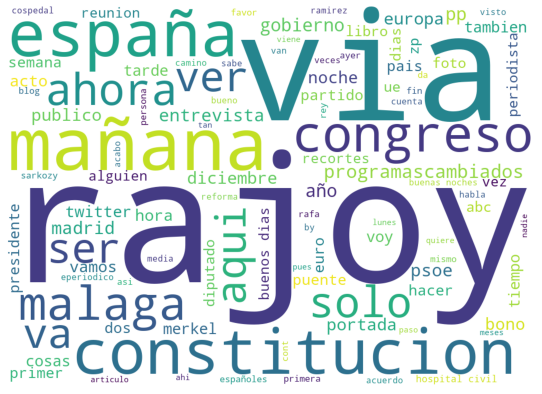

In [ ]:
#Creamos wordCloud
from wordcloud import WordCloud

datasetP=dataset[dataset['Rating_Polarity'] == 'P']
datasetN=dataset[dataset['Rating_Polarity'] == 'N']
datasetNO=dataset[dataset['Rating_Polarity'] == 'NONE']
tweets= datasetNO["Tweet"].head(1000).values
tweets=str(tweets)
print(len(tweets))
stop_words_sp = set(stopwords.words('spanish'))
stop_words_sp.update(["mas","si","dice","hoy","dia"]) 
wordcloudimage = WordCloud(
                          max_words=100,
                          max_font_size=500,
                          font_step=2,
                          stopwords=stop_words_sp,
                          background_color='white',
                          width=1000,
                          height=720
                          ).generate(tweets)
 
plt.figure(figsize=(15,7))
plt.axis("off")
plt.imshow(wordcloudimage)
wordcloudimage
plt.show()

Creación del vocabulario con 3 clases

In [ ]:
vocab={}
etiquetas=["N","NONE","P"]
numero_clases=len(etiquetas)
_tokenizer = TweetTokenizer().tokenize

for i in dataset.index:
  polaridad=dataset["Rating_Polarity"][i]
  if polaridad =="N":
    posicion=0
  elif polaridad == "NONE":
    posicion=1
  else:
    posicion=2
  for word in _tokenizer(dataset["Tweet"][i]):
    if word not in vocab.keys():
      vocab[word]=[0] * 3
      vocab[word][posicion] = 1
    else:
      vocab[word][posicion] += 1

print(vocab)

{'gonzal': [3, 7, 14], 'altozan': [1, 2, 2], 'tras': [223, 178, 178], 'presentacion': [14, 53, 61], 'de': [16761, 16390, 17262], 'libr': [73, 111, 300], 'español': [263, 273, 275], 'dios': [43, 37, 62], 'divert': [5, 0, 50], 'emocion': [16, 12, 112], 'brillant': [7, 5, 52], 'buen': [192, 506, 2682], 'noch': [91, 364, 772], 'followercet': [3, 12, 92], 'mañan': [277, 738, 783], 'va': [319, 280, 324], 'a': [7243, 6635, 9558], 'ser': [705, 678, 855], 'dia': [268, 402, 1147], 'bastant': [27, 18, 25], 'mitic': [2, 4, 17], 'par': [2819, 2437, 3736], 'contar': [2, 6, 18], 'mas': [1405, 1189, 1715], 'en': [7449, 9496, 8472], 'gacet': [18, 76, 12], 'upyd': [57, 89, 29], 'cont': [125, 259, 526], 'casi': [77, 103, 117], 'segur': [91, 78, 256], 'con': [2444, 3102, 3641], 'grup': [130, 159, 108], 'graci': [36, 35, 2346], 'for': [36, 83, 91], 'asturi': [128, 157, 121], 'dic': [893, 467, 342], 'congres': [390, 630, 377], 'felic': [6, 4, 510], 'no': [5268, 3159, 2179], 'grand': [95, 99, 563], 'anhel': 

Creación del vocabulario con 2 clases

In [ ]:
vocab={}
etiquetas=["N","P"]
numero_clases=len(etiquetas)
_tokenizer = TweetTokenizer().tokenize
    
for i in dataset.index:
  polaridad=dataset["Rating_Polarity"][i]
  if polaridad =="N":
    posicion=0
  else:
    posicion=1
  for word in _tokenizer(dataset["Tweet"][i]):
    if word not in vocab.keys():
      vocab[word]=[0] * 2
      vocab[word][posicion] = 1
    else:
      vocab[word][posicion] += 1

print(vocab)

{'gonzal': [3, 14], 'altozan': [1, 2], 'tras': [223, 178], 'presentacion': [14, 61], 'de': [16761, 17262], 'libr': [73, 300], 'español': [263, 275], 'dios': [43, 62], 'divert': [5, 50], 'emocion': [16, 112], 'brillant': [7, 52], 'buen': [192, 2682], 'noch': [91, 772], 'followercet': [3, 92], 'mañan': [277, 783], 'va': [319, 324], 'a': [7243, 9558], 'ser': [705, 855], 'dia': [268, 1147], 'bastant': [27, 25], 'mitic': [2, 17], 'par': [2819, 3736], 'contar': [2, 18], 'mas': [1405, 1715], 'en': [7449, 8472], 'gacet': [18, 12], 'upyd': [57, 29], 'cont': [125, 526], 'casi': [77, 117], 'segur': [91, 256], 'con': [2444, 3641], 'grup': [130, 108], 'graci': [36, 2346], 'for': [36, 91], 'asturi': [128, 121], 'dic': [893, 342], 'congres': [390, 377], 'felic': [6, 510], 'no': [5268, 2179], 'grand': [95, 563], 'anhel': [1, 2], 'sin': [817, 404], 'pequeñ': [35, 55], 'cos': [231, 181], 'ocurr': [31, 27], 'tod': [708, 2489], 'dias': [262, 832], 'habi': [113, 53], 'promet': [48, 86], 'respond': [75, 49]

Fórmulas de entropía y ganancia de información

In [ ]:
def entropy(probs, adjust=1e-15):
  total=0
  for prob in probs:
    if(prob>0): 
      total+= (prob + adjust) * np.math.log(prob+adjust,2)

  return total


def IG(corpus_probs, word_weigths, word_probs):

  corpus_entropy= entropy(corpus_probs) 
  word_entropy=0

  for i in range(len(word_weigths)):
    #print(i)
    word_entropy+= (word_weigths[i]* entropy(word_probs[i]))
  return corpus_entropy - word_entropy

Cálculo del IG de cada palabra en el corpus para 3 clases

In [ ]:
import operator
tweets_positivos=len(dataset_Positive)
tweets_negativos=len(dataset_Negative)
tweets_none=len(dataset_None)

tweets_totales=tweets_positivos+tweets_negativos+tweets_none

class_counts=[tweets_negativos,tweets_none,tweets_positivos]
class_probs=np.array(class_counts) / tweets_totales

vocab_entropy={}
for word in vocab.keys():
   

   #Frecuencia de la palabra en el corpus
   wc1= sum(vocab[word])
  
   #Frecuencia de la palabra de no estar en el corpus
   wc0 = tweets_totales - wc1

   #Probabilidades de la palabra de estar en cada una de las clases 
   probs_1= [vocab[word][i] / wc1  for i in range(len(vocab[word]))]

   #Probabilidades de la palabra de no estar en cada una de las clases   
   probs_0= [(class_counts[i] - vocab[word][i])  / (tweets_totales - wc1) for i in range(len(vocab[word])) ]
 
   #Probabilidades de que la palabra esté en un tweet
   p_word= wc1 / tweets_totales

   #Probabilidades de que la palabra no esté en un tweet
   p_abs_word = (tweets_totales - wc1) / tweets_totales

   #Cálculo de la entropía de cada palabra mediante IG
   vocab_entropy[word]= IG(class_probs, [p_word,p_abs_word], [probs_1, probs_0])



#vocab_entropy_ord = dict(sorted(vocab_entropy.items(),key=operator.itemgetter(1),reverse=True))
#Se ordenan por mejores valores primero
vocab_entropy_ord = dict(sorted(vocab_entropy.items(),key=operator.itemgetter(1)))


print(vocab_entropy_ord)
palabrasVocab=[]
for palabra in vocab_entropy_ord:
  palabrasVocab.append(palabra)


{'de': -0.07847116703003398, 'graci': -0.051464908759115024, 'no': -0.04194884057537829, 'buen': -0.03323791537850984, 'mejor': -0.019964164743490942, 'gran': -0.01776086081873851, 'deficit': -0.016409638838509988, 'nuev': -0.015360471501637551, 'feliz': -0.014819401065718774, 'laboral': -0.01279000166869082, 'enhorabuen': -0.01255762970081653, 'a': -0.012232900326240248, 'abraz': -0.011961916505047743, 'recort': -0.011615611341726062, 'felic': -0.011297841185686996, 'tod': -0.011021372720852796, 'port': -0.011019371032848113, 'mal': -0.009434985001947505, 'bes': -0.00789177608438374, 'reform': -0.007773087387302757, 'crisis': -0.007770377602005718, 'gobiern': -0.00770540041370249, 'huelg': -0.0076809247332914055, 'ff': -0.007440059122415965, 'amig': -0.0074021448749710395, 'encant': -0.007395828836572749, 'bien': -0.007237224093292305, 'gust': -0.006832943836632355, 'impuest': -0.00680292619277334, 'dic': -0.006692178590654185, 'eta': -0.006573525871579333, 'dia': -0.00624619979910479

Cálculo de la IG para cada palabra en el corpus con 2 clases

In [ ]:
import operator
tweets_positivos=len(dataset_Positive)
tweets_negativos=len(dataset_Negative)


tweets_totales=tweets_positivos+tweets_negativos

class_counts=[tweets_negativos,tweets_positivos]
class_probs=np.array(class_counts) / tweets_totales
vocab_entropy={}
for word in vocab.keys():
    
   #Frecuencia de la palabra en el corpus
   wc1= sum(vocab[word])
  
   #Frecuencia de la palabra de no estar en el corpus
   wc0 = tweets_totales - wc1

   #Probabilidades de la palabra de estar en cada una de las clases 
   probs_1= [vocab[word][i] / wc1  for i in range(len(vocab[word]))]

   #Probabilidades de la palabra de no estar en cada una de las clases   
   probs_0= [(class_counts[i] - vocab[word][i])  / (tweets_totales - wc1) for i in range(len(vocab[word])) ]
 
   #Probabilidades de que la palabra esté en un tweet
   p_word= wc1 / tweets_totales

   #Probabilidades de que la palabra no esté en un tweet
   p_abs_word = (tweets_totales - wc1) / tweets_totales

   #Cálculo de la entropía de cada palabra mediante IG
   vocab_entropy[word]= IG(class_probs, [p_word,p_abs_word], [probs_1, probs_0])

#vocab_entropy_ord = dict(sorted(vocab_entropy.items(),key=operator.itemgetter(1),reverse=True))
#Se ordenan por mejores valores primero
vocab_entropy_ord = dict(sorted(vocab_entropy.items(),key=operator.itemgetter(1)))

print(vocab_entropy_ord)
palabrasVocab=[]
for palabra in vocab_entropy_ord:
  palabrasVocab.append(palabra)


{'de': -0.12284131055644432, 'no': -0.06135418643857682, 'graci': -0.04444121986041527, 'buen': -0.037022325277718426, 'deficit': -0.01943950595568611, 'recort': -0.01554312613128428, 'mejor': -0.015356488829195492, 'feliz': -0.01419451365751423, 'gran': -0.013864725133535427, 'laboral': -0.013153170940554015, 'nuev': -0.012099565132184242, 'tod': -0.011263907542402696, 'enhorabuen': -0.011109406137944089, 'abraz': -0.010753135411318615, 'gobiern': -0.0105912876638935, 'mal': -0.010307296915639363, 'huelg': -0.009935500683022847, 'felic': -0.009553690346843169, 'rajoy': -0.009538306275723163, 'dic': -0.00936104841382257, 'crisis': -0.008967732130703121, 'ff': -0.008786184641564443, 'impuest': -0.008599287962209323, 'amig': -0.008151172880122237, 'noch': -0.00799786647474321, 'contr': -0.007887458565628225, 'reform': -0.00787279362448634, 'ni': -0.007418860228714297, 'eta': -0.007399904804148649, 'pag': -0.007327617580179635, 'bes': -0.007253644376388313, 'sub': -0.006865412093258971, '

Se realizará *One Hot Encoding* en la columna `Rating_Polarity`. Esta técnica, codifica las características categóricas como una matriz numérica de un solo uso. La entrada a este transformador debe ser una matriz de números enteros o cadenas de texto, denotando los valores tomados por características categóricas (discretas). Se crea una columna binaria para cada categoría y devuelve una matriz dispersa.

In [ ]:
one_hot = pd.get_dummies(dataset["Rating_Polarity"])
dataset.drop(['Rating_Polarity'], axis = 1, inplace = True)
dataset = pd.concat([dataset, one_hot], axis = 1)
dataset

,Tweet,N,NONE,P
2,gonzalo altozano tras presentacion d...,0,0,1
6,buenas noches followercetes mañana ...,0,0,1
7,mas de mañana en gaceta upyd cont...,0,0,1
8,felicidad no en grandes anhelos ...,0,0,1
11,habia prometido responder a s...,0,0,1
...,...,...,...,...
72123,cuarto aqui,0,1,0
72124,no des en serio,0,1,0
72133,md abiertos crushes,0,1,0
72137,lx ps conmigo,0,1,0


# 4.Datos de entrenamiento y Test

Se divide el *dataset* en dos, 30% para test y 70% para entrenamiento

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
X = dataset['Tweet'].values
y = dataset.drop('Tweet', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

Creación del vocabulario del Corpus


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import array
from numpy import asarray
from numpy import zeros

tokenizer = Tokenizer(num_words=10000,oov_token='<OOV>')
#Se crea el diccionario a partir de las mejores 10000 palabras
tokenizer.fit_on_texts(palabrasVocab[:10000])
#tokenizer.fit_on_texts(X_train)
#tokenizer.fit_on_texts(X_test)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
maxlen = 33

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)




45403


Usar esta forma de aplicar la técnia glove.
Para ello se usa un diccionario de palabras preentrenadas en las que cada palabra es representada por un vector. Aquellas palabras que sean similares tendran un vector similar.

Incrustación de palabras con Glove

In [ ]:
embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/TFG/cc.es.300.vec', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype="float32")
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()


embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Incrustacion de palabras con Word2Vec

In [ ]:
Word2Vec_file = open('/content/drive/MyDrive/TFG/embeddings-l-model.vec', encoding="utf8")
embeddings_dictionary = dict()

for line in Word2Vec_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype="float32")
    embeddings_dictionary [word] = vector_dimensions
Word2Vec_file.close()


embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


# 5.Modelo

Para ello, se utilizará *TensorFlow* y la librería *Keras* 

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Para el modelo, se utilizarán las capas más sencillas (`Dense`), en ellas, se aplicará la función de activación *ReLU* <sup>[86] [87]</sup> para las tres primeras, y para la última, *Softmax* <sup>[87]</sup>.

**Función de activación ReLU:** La función de activación de unidad lineal rectificada (o *rectified linear unit  activation function*, *ReLU*) es la función de activación más utilizada para aplicaciones de aprendizaje profundo con resultados más exitosos y más ampliamente utilizada. La función *ReLU* representa una función casi lineal y, por lo tanto, conserva las propiedades de los modelos lineales, con métodos de descenso de gradiente.
La función de activación de *ReLU* realiza una operación de umbral para cada elemento de entrada donde los valores menores que 0 se establecen en 0, por lo que la función *ReLU* viene dado por, <sup>[87]</sup>

>$f\left ( x \right ) = \max\left ( 0,x \right ) = \left\{\begin{matrix}
x_{i}, & si \; \; x_{i} \geq 0 \\ 0, & si \; \; x_{i} < 0
\end{matrix}\right.$

La principal ventaja de utilizar *ReLU* en el cálculo es que garantiza un cálculo más rápido, ya que no se calculan exponenciales ni divisiones, con una velocidad global de cálculo mejorada. <sup>[87]</sup>

**Función de activación Softmax:** Se utiliza para calcular la distribución de probabilidad a partir de un vector de números reales. La función *Softmax* produce una salida en un rango de valores entre 0 y 1, con la suma de las probabilidades siendo igual a 1. La función Softmax se calcula usando la relación: <sup>[87]</sup>

>$f\left ( x_{i} \right ) = \frac{exp\left ( x_{i} \right )}{\sum_{j}^{exp\left ( x_{j} \right )}}$ 

La función Softmax se utiliza en modelos multiclase, donde se devuelven probabilidades de cada clase, siendo la clase objetivo la que tiene la probabilidad más alta. La función Softmax aparece principalmente en casi todas las capas de salida de las arquitecturas de aprendizaje profundo, donde se utilizan. <sup>[87]</sup>

CNN + LSTM Model

In [ ]:
from keras.layers.pooling import GlobalMaxPool1D
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.layers import Embedding, Flatten, Dense, LSTM, Conv1D, GlobalMaxPooling1D, MaxPooling1D,BatchNormalization, Bidirectional,GRU
from keras.utils.vis_utils import plot_model


model = Sequential()
#embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
#model.add(embedding_layer)
embedding_layer = Embedding(vocab_size, 200, input_length=maxlen)
model.add(embedding_layer)


#Convolucional
model.add(Conv1D(192, 8, activation='relu'))

model.add(MaxPooling1D(10))

#LSTM
model.add(LSTM(96, dropout=0.2, recurrent_dropout=0.3))

model.add(Dense(3, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])



10002


Creación del early-stop para evitar sobreajuste

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 0)

In [ ]:
print(model.summary())
model.fit(x = X_train, y = y_train, 
          batch_size = 256, 
          epochs = 100, 
          validation_data = (X_test, y_test), 
          verbose = 1, 
          callbacks = [early_stop])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 33, 200)           4000400   
                                                                 
 conv1d_2 (Conv1D)           (None, 26, 192)           307392    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 2, 192)           0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 96)                110976    
                                                                 
 dense_2 (Dense)             (None, 3)                 291       
                                                                 
Total params: 4,419,059
Trainable params: 4,419,059
Non-trainable params: 0
____________________________________________

Validación Cruzada Modelo Híbrido

In [ ]:
from keras.models import Sequential
from sklearn.utils.multiclass import type_of_target
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from keras.layers import Embedding, Flatten, Dense, LSTM, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Bidirectional, GRU
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
import statistics

X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

#y=np.argmax(y,axis=1)
print(type_of_target(y))
acc_per_fold=[]
loss_per_fold=[]
print(type_of_target(y))
kf=KFold(n_splits=10, shuffle=True, random_state=999)
cvscores=[]
for train, test in kf.split(X_train, y_train):
  model = Sequential()
  embedding_layer = Embedding(vocab_size, 200, input_length=maxlen)
  #embedding_layer = Embedding(vocab_size, 300, input_length=maxlen, weights=[embedding_matrix],trainable=False)

  model.add(embedding_layer)

  model.add(Conv1D(192, 8, activation='relu')) 

  model.add(MaxPooling1D(10))

  model.add(LSTM(96, dropout=0.2, recurrent_dropout=0.3))



  #Si queremos 3 clases usaremos 3 neuronas en la última capa densa, por el contrario usaremos 4
  model.add(Dense(3, activation='softmax'))
   #Si queremos 2 clases usaremos 3 neuronas en la última capa densa, por el contrario usaremos 4
  #model.add(Dense(2, activation='softmax'))
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

  model.summary()
  

  early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 0)
  model.fit(X[train], y[train], epochs=100, batch_size=256, verbose=1,validation_data = (X[test], y[test]), callbacks=[early_stop])

  scores = model.evaluate(X[test], y[test], verbose=1)
  print(f'Score for fold : {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
print(acc_per_fold)
print(statistics.mean(acc_per_fold))

multilabel-indicator
multilabel-indicator
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 33, 200)           9080600   
                                                                 
 conv1d_10 (Conv1D)          (None, 26, 192)           307392    
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 2, 192)           0         
 g1D)                                                            
                                                                 
 lstm_10 (LSTM)              (None, 96)                110976    
                                                                 
 dense_10 (Dense)            (None, 3)                 291       
                                                                 
Total params: 9,499,259
Trainable params: 9,499,259
Non-trainable params: 0
_

Descarga de keras-tuner

In [ ]:
#Hipertuning con Keras Turner

!pip install keras-tuner

Búsqueda de hiperparámetros con keras-tuner

In [ ]:
import keras_tuner as tk
from kerastuner.tuners import RandomSearch
from keras import callbacks
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Bidirectional, GRU
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')


def createModel(hp):
    
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 200, input_length=maxlen)
    model.add(embedding_layer)
    #neuronsConv = hp.Int('unitsconv', min_value=64, max_value=256, step=32)
    #neuronsLSTM = hp.Int('unitsLSTM', min_value=64, max_value=128, step=32)
    kernelSize= hp.Choice('kernel_size', values=[3,5,8])
    dropout_N=hp.Choice('dropout_N', values=[0.2,0.3,0.4])
    dropout_R=hp.Choice('dropout_R', values=[0.2,0.3,0.4])

    model.add(Conv1D(192, kernel_size=kernelSize, activation='relu'))


    #pooling=hp.Choice('Maxpooling1D', values=[3,5,10])

    model.add(MaxPooling1D(10))

    #model.add(GlobalMaxPooling1D())
    
   # model.add(GRU(32, dropout=0.2, recurrent_dropout=0.3))

    #model.add(GRU(32, dropout=0.2, recurrent_dropout=0.3,return_sequences=True))
    model.add(LSTM(96, dropout=dropout_N, recurrent_dropout=dropout_R))

    #Convolucionales
    #model.add(Conv1D(128, 7, activation='relu'))

    #model.add(MaxPooling1D(10))
    #model.add(Conv1D(128, 7, activation='relu'))


    #model.add(GlobalMaxPooling1D())

    #learning_rate = hp.Choice('learning_rate', values=[0.0001,0.001,0.01,0.1,0.0002,0.02])
  
    #loss = hp.Choice('loss', values=['binary_crossentropy','categorical_crossentropy'])
    #optimizer= hp.Choice('optimizer', values=['adam','rmsprop'])
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

tuner = RandomSearch(createModel,
                     objective="val_accuracy",
                     max_trials=12, 
                     executions_per_trial=1, 
                     directory='tuner12', 
                     project_name='Pruebitdas33Hibrid')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


Visualización de lista de hiperparámetros configurables

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 8], 'ordered': True}
dropout_N (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
dropout_R (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}


Entrenamiento del modelo con las combinaciones de hiperparámetros

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience=0)
tuner.search(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_test, y_test), callbacks=[early_stop],verbose=1)

Trial 12 Complete [00h 04m 16s]
val_accuracy: 0.7391977310180664

Best val_accuracy So Far: 0.7433105707168579
Total elapsed time: 00h 35m 44s
INFO:tensorflow:Oracle triggered exit


Resumen de mejores resultados

In [ ]:
tuner.results_summary() 


Results summary
Results in tuner12/Pruebitdas33Hibrid
Showing 10 best trials
Trial summary
Hyperparameters:
kernel_size: 8
dropout_N: 0.2
dropout_R: 0.3
Score: 0.7433105707168579
Trial summary
Hyperparameters:
kernel_size: 8
dropout_N: 0.2
dropout_R: 0.2
Score: 0.7410364151000977
Trial summary
Hyperparameters:
kernel_size: 3
dropout_N: 0.2
dropout_R: 0.4
Score: 0.7403106689453125
Trial summary
Hyperparameters:
kernel_size: 5
dropout_N: 0.4
dropout_R: 0.4
Score: 0.739536464214325
Trial summary
Hyperparameters:
kernel_size: 8
dropout_N: 0.3
dropout_R: 0.2
Score: 0.7391977310180664
Trial summary
Hyperparameters:
kernel_size: 8
dropout_N: 0.4
dropout_R: 0.3
Score: 0.7390041947364807
Trial summary
Hyperparameters:
kernel_size: 3
dropout_N: 0.3
dropout_R: 0.3
Score: 0.7383267879486084
Trial summary
Hyperparameters:
kernel_size: 5
dropout_N: 0.4
dropout_R: 0.2
Score: 0.7371655106544495
Trial summary
Hyperparameters:
kernel_size: 3
dropout_N: 0.3
dropout_R: 0.2
Score: 0.7364881038665771
Trial 

#6.Evaluación del modelo

**Se** va a crear un *dataframe* que contenga los valores obtenidos por *epoch*.

In [ ]:
df_modelo = pd.DataFrame(model.history.history)

In [ ]:
df_modelo['Epoch'] = range(1, df_modelo.shape[0] + 1)
df_modelo.index = df_modelo['Epoch']
df_modelo

,Epoch
Epoch,


A continuación, se calcula la precisión (*accuracy*) del modelo,

In [ ]:
score = model.evaluate(X_test, y_test, batch_size = 256, verbose = 1)

print('\nAccuracy - Datos Test:', round(score[1], 4))

69/69 [==============================] - 9s 125ms/step - loss: 0.5781 - accuracy: 0.7554

Accuracy - Datos Test: 0.7554


Finalmente, se van a calcular las prediciones para calcular la matriz de confusión del modelo (`confusion_matrix`).

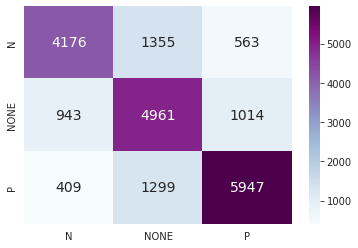

In [ ]:
from sklearn.metrics import confusion_matrix

prediccion = model.predict(X_test)
matriz_confusion = confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(prediccion, axis = 1))
df_matriz_confusion = pd.DataFrame(matriz_confusion, 
                                   #index = dataset.columns[1:4],
                                  # columns = dataset.columns[1:4])
                                   index = dataset.columns[1:5],
                                    columns = dataset.columns[1:5])
plt.figure(figsize = (6, 4))
sns.heatmap(df_matriz_confusion, annot = True,fmt='g', annot_kws={"size": 14}, cmap = 'BuPu');

También se crea un informe que muestra las principales métricas de la clasificación (classification_report).

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_test, axis = 1), np.argmax(prediccion, axis = 1)))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4713
           1       0.91      0.93      0.92      6618

    accuracy                           0.91     11331
   macro avg       0.91      0.90      0.90     11331
weighted avg       0.91      0.91      0.91     11331

